In [1]:
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import albumentations as albu
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold

from utils.trainer import NNTrainer
from utils.data import MyDataset, get_train_transforms, get_valid_transforms

import efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from torchvision import models

from utils.models import EffNetMSD

In [2]:
data_path = './test/'
models_path = './models_pl/'

models = [['efficientnet-b5', f'{models_path}/eff5_1/'],
          ['efficientnet-b4', f'{models_path}/eff4_1/'],
          ['efficientnet-b3', f'{models_path}/eff3_4/']]

In [3]:
cfg = {'advprop' : False,
       'img_size' : 512,
       'batch_size' : 32,
       'n_dropouts' : 30,
       'tta' : 10,
       'random_state' : 123,
       'device' : 'cuda',
       
}
cfg['augmentations'] = get_train_transforms

In [ ]:
sub = 

In [4]:
dataset = MyDataset(path_extra=data_path, extra_df=sub, img_size=cfg['img_size'],\
                              augmentations=cfg['augmentations'](cfg['img_size']),\
                              advprop=cfg['advprop'], two_samples=False)

dataloader = DataLoader(dataset, batch_size=cfg['batch_size'], drop_last=False, shuffle=False)

In [5]:
preds = []
pred_probas = None
for model_name, path in models:
    model = EffNetMSD(net=model_name, advprop=cfg['advprop'], n_dropouts=cfg['n_dropouts'])
    model_weights_files = [f'{path}/{x}' for x in os.listdir(path)]
    for model_weights_file in model_weights_files:
        model.load_state_dict(torch.load(model_weights_file, map_location=cfg['device']))
        trainer = NNTrainer(model, device=cfg['device'], label_names=[0, 1, 2, 3, 4],\
                            model_name=model_name)
        pred, pred_proba = trainer.test(dataloader, tta=cfg['tta'],\
                                        show_results=True, verbose=True, log=False)
        if pred_probas is None:
            pred_probas = pred_proba
        else:
            pred_probas += pred_proba
        preds.append(pred)
        
        del trainer
        torch.cuda.empty_cache()
    del model
    torch.cuda.empty_cache()
        
pred_probas /= len(preds)

Loaded pretrained weights for efficientnet-b3


In [6]:
np.sum(pred_probas, axis=1)

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [21]:
sum([len(z) for z in [[1 for y in x if y==np.nan] for x in pred_probas]])

0

In [8]:
labels = np.median(np.hstack(preds), axis=1).astype(int)

In [9]:
image_ids = [x.split('/')[-1] for x in dataloader.dataset.data]

In [54]:
labeled_df = pd.DataFrame(image_ids, columns=['image_id'])
labeled_df['median_label'] = labels

In [55]:
labeled_df['median_proportion'] = (np.hstack(preds) == labels.reshape(-1, 1)).astype(int).\
                                   sum(axis=1).astype(float)/len(preds)

In [56]:
for i in range(5):
    labeled_df[f'class{i}'] = pred_probas[:, i]

In [57]:
labeled_df['max_proba'] = pred_probas.max(axis=1)

In [58]:
labeled_df['label'] = pred_probas.argmax(axis=1)

In [59]:
labeled_df.shape

(16369, 10)

In [61]:
labeled_df[labeled_df['label'] != labeled_df['median_label']].shape

(1329, 10)

In [48]:
labeled_df[labeled_df['max_proba'] < 0.75].shape

(1893, 9)

In [51]:
labeled_df.to_csv('pl_df.csv', index=False)

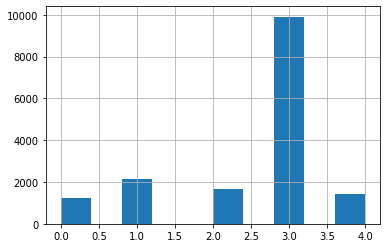

In [52]:
labeled_df.label.hist()